In [130]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [131]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

<Figure size 640x480 with 0 Axes>

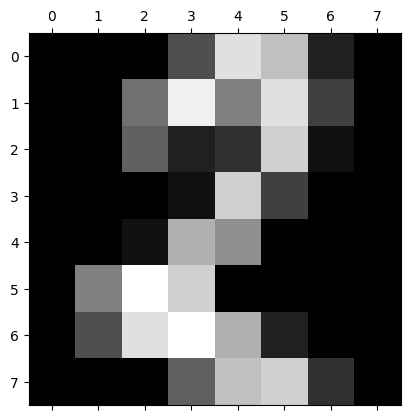

2


In [132]:
digits = load_digits()
data = digits.data
targets = digits.target
norm_data = normalize(data, axis=0)
n=50
plt.gray()
plt.matshow(digits.images[n])
plt.show()
print(targets[n])

In [133]:
#train split and test split
train_data, test_data, train_targets, test_targets = train_test_split(norm_data, targets, train_size=0.8)

#train targets converted to one-hot format for loss calculation
train_targets_1hot = np.zeros((train_targets.shape[0], 10))
for index, value in enumerate(train_targets):
  train_targets_1hot[index, value] = 1
  
#test targets converted to one-hot format for loss calculation
test_targets_1hot = np.zeros((test_targets.shape[0], 10))
for index, value in enumerate(test_targets):
  test_targets_1hot[index, value] = 1

#**2-Layer ANN using Numpy**

In [134]:
# Equation of Layer
def compute(weights,input,bias):
  # We are calculating these vectors for the whole dataset
  # Not for one data point
  c1=np.dot(weights, input.T)
  c2=np.tile(bias,(input.shape[0],1)).T
  z=c1+c2
  z=z.T
  return z

In [135]:
# activation
tanh = lambda x : np.tanh(x)

In [136]:
# defining softmax function
# Here, we are performing softmax operation on entire dataset
# Using vectorized coding
def softmax(z):
  exp_mat=np.exp(z)
  sum_exp=np.sum(exp_mat,axis=1)
  sftmax=exp_mat.T/sum_exp
  return sftmax.T

In [137]:
# Feed Forward
def feed_forward(inputs,W_h,W_o,b_h,b_o):
  z1=compute(W_h,inputs,b_h)
  a1=tanh(z1)
  z2=compute(W_o,a1,b_o)
  a2=softmax(z2)
  return z1,a1,z2,a2

In [138]:
# Function to Calculate Average CE Loss
def averageCE(pred_mat,train_1hot):
  log_score=np.log(pred_mat)
  avg_CE=log_score*train_1hot
  avg_CE=-(np.sum(avg_CE))/(train_1hot.shape[0])
  
  return avg_CE

In [139]:
# Defining function which gives gradient wrt to outer layer units (Z2)

def gradCE_out(pred_mat,train_1hot):

  grad= pred_mat - train_1hot

  return grad

In [140]:
# Gradient of loss fn. with respect to outer layer bias

def grad_bo(pred_mat,train_1hot):
  grad=np.sum(gradCE_out(pred_mat,train_1hot),axis=0)/(train_1hot.shape[0])
  return grad

In [141]:
# Gradient of loss fn. with respect to outer layer weights

def grad_Wo(pred_mat,train_1hot,a1):
  d1=gradCE_out(pred_mat,train_1hot)
  grad=(d1.T)@(a1)/(train_1hot.shape[0])
  return grad

In [142]:
def d_tanh(x):
  d_=(((np.cosh(x))**(-2)))
  return d_

In [143]:
# Gradient with respect to z1

def grad_z1(pred_mat,train_1hot,W_o,z1):
  grad=(gradCE_out(pred_mat,train_1hot)@W_o)*d_tanh(z1)
  return grad

In [144]:
# Gradient of loss fn. with respect to hidden layer bias

def grad_bh(pred_mat,train_1hot,W_o,z1):
  dz1=grad_z1(pred_mat,train_1hot,W_o,z1)
  grad=np.sum((dz1),axis=0)/(train_1hot.shape[0])
  return grad

In [145]:
# Gradient of loss fn. with respect to hidden layer weights

def grad_Wh(pred_mat,train_1hot,W_o,z1,input):
  dz1=grad_z1(pred_mat,train_1hot,W_o,z1)
  grad=(dz1.T)@(input)/(train_1hot.shape[0])
  return grad

In [146]:
# Grad Clip Function

def gradClip(x):
  grad=np.clip(x,-1,1)
  return grad

In [147]:
# Defining a function which takes number of hidden units,
# and initializes the network with random weights
def Weights(hidden_units,gaus=np.random.normal):
  W_h = gaus(0,1,(hidden_units, 64))
  W_o = gaus(0,1,(10, hidden_units))
  b_h = gaus(0,1,(hidden_units))
  b_o = gaus(0,1,(10))
  return W_h,W_o,b_h,b_o

In [148]:
(train_data[0:100]).shape

(100, 64)

In [149]:
# Training the network
def network_train(train_data,train_1hot,test_data,test_1hot,test_targets,
                  hidden_units,epochs,learning_rate,momentum):
  W_h,W_o,b_h,b_o=Weights(hidden_units)
  W_hv,W_ov,b_hv,b_ov=W_h*(1e-5),W_o*(1e-5),b_h*(1e-5),b_o*(1e-5)
  
  learning_rate_i=learning_rate

  losses_train=np.zeros(epochs)
  losses_test=np.zeros(epochs)
  accuracy_test=np.zeros(epochs)

  for i in range(0,epochs):

    _t,__t,___t,pm_train=feed_forward(train_data,W_h,W_o,b_h,b_o)
    _,__,___,pm_test=feed_forward(test_data,W_h,W_o,b_h,b_o)

    pred_test=np.array([np.argmax(pm_test[i]) for i in range(0,len(pm_test))])
    accuracy_test[i]=(accuracy_score(test_targets,pred_test))*100

    losses_train[i]=averageCE(pm_train,train_1hot)
    losses_test[i]=averageCE(pm_test,test_1hot)

    # This neural network is prone to overflow
    # Therefore, we need to stop training if overflow occurs

    if np.max(___t)>100:
      losses_train[i+1:]=np.nan
      losses_test[i+1:]=np.nan
      accuracy_test[i+1:]=np.nan
      return losses_train,losses_test,accuracy_test,W_h,W_o,b_h,b_o
     
    b=int(np.floor(train_data.shape[0]/20))

    for j in range(0,b):

      z1,a1,z2,pm_train_mini=feed_forward(train_data[20*j:20*j+20],W_h,W_o,b_h,b_o)
 
      b_hv=momentum*b_hv+learning_rate*gradClip(grad_bh(pm_train_mini,train_1hot[20*j:20*j+20],W_o,z1)) 
      b_h=b_h-b_hv   

      W_hv=momentum*W_hv+learning_rate*gradClip(grad_Wh(pm_train_mini,train_1hot[20*j:20*j+20],W_o,z1,train_data[20*j:20*j+20]))
      W_h=W_h-W_hv

      b_ov=momentum*b_ov+learning_rate*gradClip(grad_bo(pm_train_mini,train_1hot[20*j:20*j+20]))
      b_o=b_o-b_ov

      W_ov=momentum*W_ov+learning_rate*gradClip(grad_Wo(pm_train_mini,train_1hot[20*j:20*j+20],a1))
      W_o=W_o-W_ov   

  return losses_train,losses_test,accuracy_test,W_h,W_o,b_h,b_o

In [150]:
from sklearn.metrics import accuracy_score

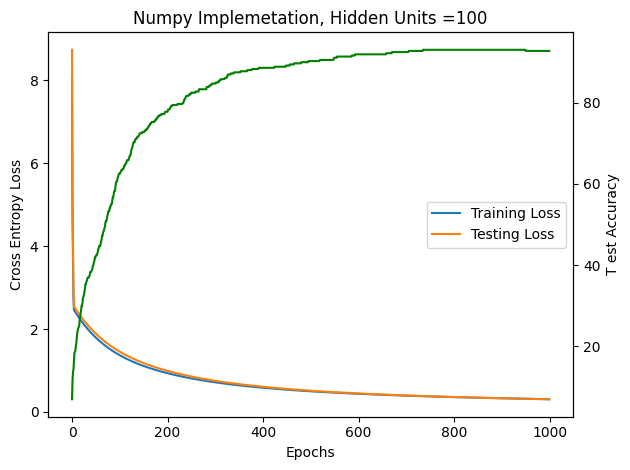

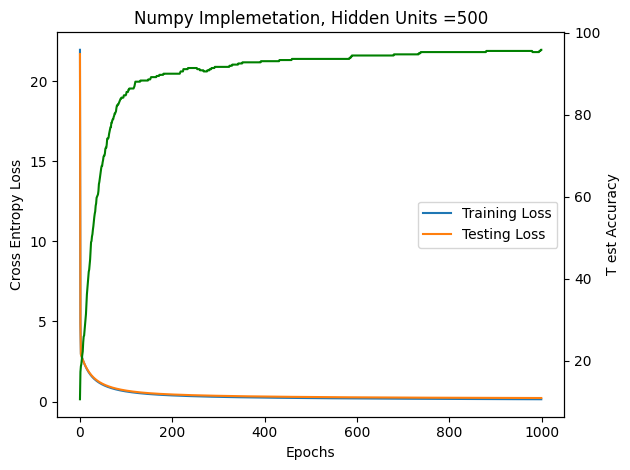

In [151]:
Accuracy_Training=[]
Accuracy_Testing=[]

for h in [100,500]:
    losses_train,losses_test,accuracy_test,W_h,W_o,b_h,b_o = network_train(
        train_data,train_targets_1hot,test_data,test_targets_1hot,test_targets,h,1000,0.001,0.8)

    fig,ax1=plt.subplots()
    ax1.plot(losses_train,label='Training Loss')
    ax1.plot(losses_test,label='Testing Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Cross Entropy Loss')
    ax1.set_title('Numpy Implemetation, Hidden Units =' + str(h))
    plt.legend(loc='center right')

    ax2 = ax1.twinx()
    ax2.plot(accuracy_test,label='Testing Accuracy',color='green')
    ax2.set_ylabel('T est Accuracy')
    fig.tight_layout() 
        
    plt.show()

#**2-Layer ANN using Pytorch**

In [152]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim

torch.manual_seed(10) 

In [153]:
# Defining function which trains the neural network using Pytorch
def nnet_train_py(hidden_units,epochs,learning_rate,momentum_,
                  train_data,train_1hot,test_data,test_1hot,test_targets):

  class nnet(nn.Module):

    def __init__(self):
        super(nnet, self).__init__()
        self.layer1 = nn.Linear(train_data.shape[1], hidden_units)
        self.layer2 = nn.Linear(hidden_units, 10)

    def forward(self, img_data):
        z1 = self.layer1(img_data)
        a1 = torch.tanh(z1)
        z2 = self.layer2(a1)
        return z2

  NNET=nnet()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(NNET.parameters(), lr=learning_rate, momentum=momentum_)

  losses_train=np.zeros(epochs)
  losses_test=np.zeros(epochs)
  accuracy_test=np.zeros(epochs)

  for i in range(0,epochs):

    targets_train = torch.tensor(train_1hot)
    input=torch.tensor(train_data)
    input=input.view(-1, train_data.shape[1])
    input=input.to(torch.float32)
    preds_train = NNET(input)
    losses_train[i]=criterion(preds_train,targets_train)

    targets_test = torch.tensor(test_1hot)
    input=torch.tensor(test_data)
    input=input.view(-1, test_data.shape[1])
    input=input.to(torch.float32)
    preds_test = NNET(input)
    losses_test[i]=criterion(preds_test,targets_test)

    preds_test=preds_test.detach().numpy()
    pred_test=np.array([np.argmax(preds_test[i]) for i in range(0,len(preds_test))])
    accuracy_test[i]=(accuracy_score(test_targets,pred_test))*100
     
    b=int(np.floor(train_data.shape[0]/20))

    for j in range(0,b):

      targets_mini = torch.tensor(train_1hot[20*j:20*j+20])
      input=torch.tensor(train_data[20*j:20*j+20])
      input=input.view(-1, train_data.shape[1])
      input=input.to(torch.float32)
      preds_mini = NNET(input)
    
      # updating the parameters
      loss1___ = criterion(preds_mini, targets_mini)     
      loss1___.backward()             
      optimizer.step()             
      optimizer.zero_grad()  

  return losses_train,losses_test,accuracy_test

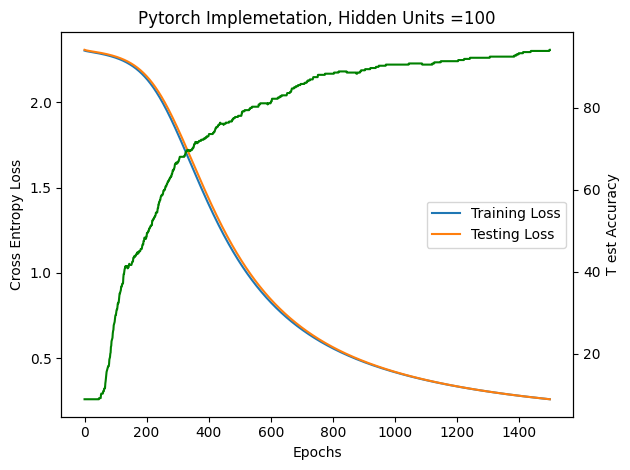

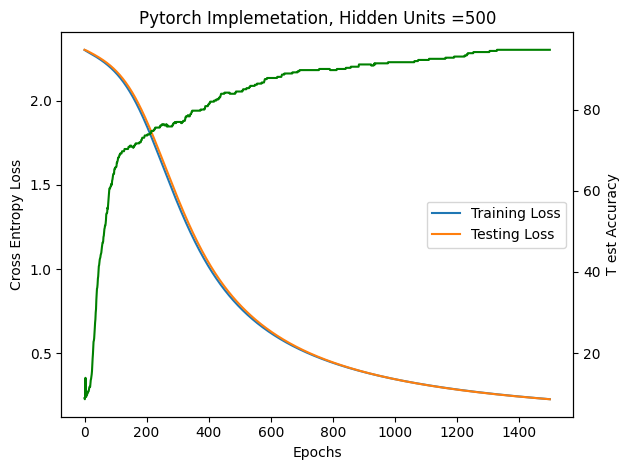

In [154]:
for h in [100,500]:
    losses_train,losses_test,accuracy_test = nnet_train_py(h,1500,
                0.001,0.9,train_data,train_targets_1hot,test_data,test_targets_1hot,test_targets)

    fig,ax1=plt.subplots()
    ax1.plot(losses_train,label='Training Loss')
    ax1.plot(losses_test,label='Testing Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Cross Entropy Loss')
    ax1.set_title('Pytorch Implemetation, Hidden Units =' + str(h))
    plt.legend(loc='center right')

    ax2 = ax1.twinx()
    ax2.plot(accuracy_test,label='Testing Accuracy',color='green')
    ax2.set_ylabel('T est Accuracy')
    fig.tight_layout() 
        
    plt.show()